# Binarización

------------------------------------------------------------------
La binarización es un proceso por el cual se convierte la imagen recibida en una imagen binaria (con valores de intensidad de pixel de 1 ó 0) separando así el fondo de los objetos a analizar.
Vamos a analizar distintos métodos de binarización de imágenes, trabajando sobre la muestra "Sombreado.png". Se pueden dividir en dos tipos:

1. Globales: Tratan de encontrar un umbral el cual aplicar a toda la imagen, entre estos se encuentran los métodos por umbral y Otsu. 
2. Locales: Obtiene el umbral para cada pixel en la imagen usando para ello los valores de sus vecinos, entre estos se encuentran el método de Nilblack, Saovola, Bernsen.

De los métodos mencionados anteriormente sólo entraremos en desarrollo del método de umbral fijo, Otsu y Bernsen.



In [1]:
#Si queremos que las imágenes sean mostradas en una ventana emergente quitar el inline
%matplotlib inline

# OpenCV-Python utiliza NumPy para el manejo de imágenes
import numpy as np
# cv2 es el módulo python para acceder a OpenCV 
import cv2 as cv
# Usamos las poderosas herramientas de graficación de matplotlib para mostrar imágenes, perfiles, histogramas, etc
import matplotlib.pyplot as plt

In [2]:
# Cargamos la imagen en modo monocromático
img = cv.imread('Sombreado.png',cv.IMREAD_GRAYSCALE)

## Búsqueda manual del umbral

+ Ejercicio: Completar lo que falte y comparar contra el método de Otsu (por ejemplo restando las salidas)

In [3]:
#Paso1: Definir umbral inicial (media de la imagen)
media = img.mean()
print("Media: ", media)

Media:  92.83803140010036


### Definimos las funciones que vamos a utilizar

In [4]:
#Funcion para dividir la imagen en dos partes en base al umbral de entrada

def dividir_imagen(img, umbral_inicial):
    p1,p2 = [],[]
    
    alto,ancho = img.shape
    
    for i in range(alto):
        for j in range(ancho):
            if img[i,j] > umbral_inicial:
                p1.append(img[i,j])
            else:
                p2.append(img[i,j])

    parte1,parte2 = np.array(p1),np.array(p2)
    
    return parte1,parte2

In [5]:
def buscar_umbral(img, umbral=128,delta_T=1.0):
    
    #Paso2: Dividir la imagen en dos partes
    parte1,parte2 = dividir_imagen(img, umbral)

    #Paso3: Encontrar la media de cada parte
    media_p1 = parte1.mean()
    media_p2 = parte2.mean()

    #Paso4: Calcular el nuevo umbral (promedio entre media anterior y actual)
    nuevo_umbral = (media_p1 + media_p2) / 2

    #Paso5: Criterio de detención (o recalculo)
    if abs(nuevo_umbral - umbral)< delta_T:
        return nuevo_umbral
    else:
        return buscar_umbral(img, umbral=nuevo_umbral, delta_T=1.0)

+ Finalmente mostramos el nuevo umbral hallado

In [6]:
umbral_img = buscar_umbral(img, media, 1.0)

print("Nuevo umbral encontrado: ", umbral_img)

Nuevo umbral encontrado:  99.78516187710079


## Métodos Globales

+ Ahora realizamos el procesamiento de la imagen con las funciones que proporciona opencv siendo "cv.THRESH_BINARY" y cv.THRESH_BINARY+cv.THRESH_OTSU los flags correspondientes al umbral fijo y el método Otsu respectivamente.

#### 1. Umbral (Embebida - Fijo) 

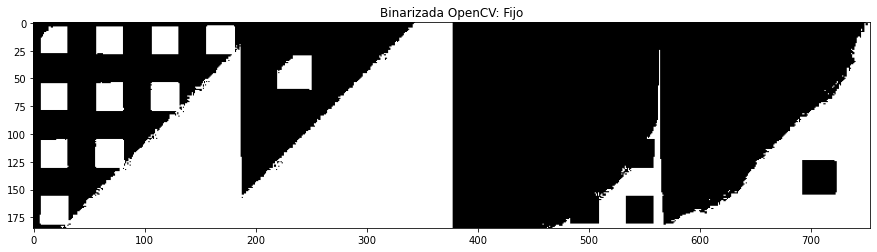

In [7]:
#Parámetros: Imag_original,umbral,valor_máximo,método

ret, thresh_fijo = cv.threshold(img,umbral_img,255,cv.THRESH_BINARY)
plt.figure(figsize=(15,4))
plt.imshow(thresh_fijo,cmap='gray')
plt.title('Binarizada OpenCV: Fijo')
plt.show()

#### 2. Otsu (Embebida- Fijo)

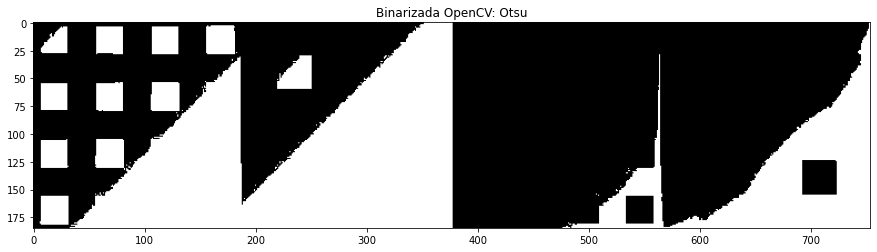

In [8]:
#Parámetros: Imag_original,umbral,valor_máximo,método

ret, thresh_otzu = cv.threshold(img,120,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
plt.figure(figsize=(15,4))
plt.imshow(thresh_otzu,cmap='gray')
plt.title('Binarizada OpenCV: Otsu')
plt.show()

## Análisis de Resultados y comparación

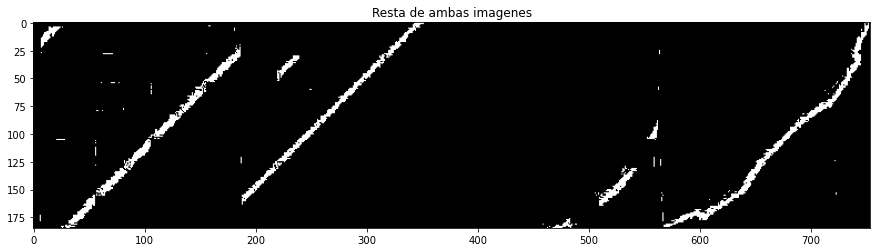

In [9]:
# Comparamos restando las imagenes obtenidas con el binarizado fijo y el binarizado de Otzu

resta = cv.subtract(thresh_fijo,thresh_otzu)

plt.figure(figsize=(15,4))
plt.imshow(resta,cmap='gray')
plt.title('Resta de ambas imagenes')
plt.show()

+ Podemos observar que las líneas blancas de la resta de ambas imágenes denota las diferencias entre ellas, siendo estas muy leves en las partes continuas y abruptas en los cambios de intensidad (bordes). Si bien estas diferencias no representan un cambio significativo en el reconocimiento de los objetos, el método Otsu posee mejor definición en los bordes de los bloques oscuros, mientras que el método por umbral fijo denota mejor los bloques blancos. 

## Implementar 2: Binarización local, método Bernsen

Implementar método de Bernsen de para una ventana de 3x3, 5x5 o 7x7.
 
 + Contraste = Máximo - Mínimo
 + Gris_medio = Media
 + Contraste_referencia = ?
     
     if(contraste_local < contraste_referencia)
         pixel=(gris_medio >= 128)? objeto:background
     else
         pixel=(pixel >= gris_medio)? objeto:background
         
 + Asigno al pixel un valor de objeto (255) o un valor de background (0)

#### Definimos la función  del método de Bernsen
+ Esta función recibe la imagen a analizar, el contraste de referencia y el tamaño de la ventana (3x3, 5x5, 7x7). Luego se realiza una copia de la imagen para no afectar los valores de la original, se obtienen las dimensiones de la misma en alto y ancho y luego se definen los límites de procesamiento. Este último paso es necesario para evitar problemas de bordes con las ventanas. Una vez adquiridos los párametros de procesamiento se recorre la imagen y asociandole a cada pixel su ventana correspondiente, de la cual se obtendrá el contraste y su gris medio. Finalmente, le asigna 1 ó 0 al pixel dependiendo de la comparación de estos valores con el contraste de referencia. 

In [10]:
def metodo_bernsen_ventana(img, contraste_ref,tam):
    img_bernsen=img.copy()  
    alto,ancho =img.shape
    
    #definimos los límites de procesamiento
    inicio = (tam//2)+1
    fin_alto = alto-inicio+1
    fin_ancho = ancho-inicio+1
    
    #recorremos la imagen
    for i in range(inicio, fin_alto):
        for j in range(inicio, fin_ancho):
            pixel = img[i,j]
            ventana = img[i:(i+tam),j:(j+tam)]
            minimo = np.amin(ventana)
            maximo = np.amax(ventana)
            contraste_local = maximo - minimo
            gris_medio = ventana.mean() 
            
            
            if contraste_local < contraste_ref:
                img_bernsen[i,j] = 255 if gris_medio >= 128 else 0
               
            else:
                img_bernsen[i,j] = 255 if pixel >= gris_medio else 0
               
        
    return img_bernsen

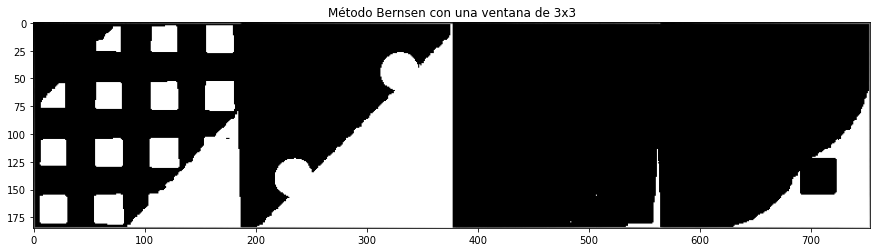

In [15]:
img2=metodo_bernsen_ventana(img,100,3)
plt.figure(figsize=(15,4))
plt.imshow(img2, cmap="gray")
plt.title('Método Bernsen con una ventana de 3x3')
plt.show()

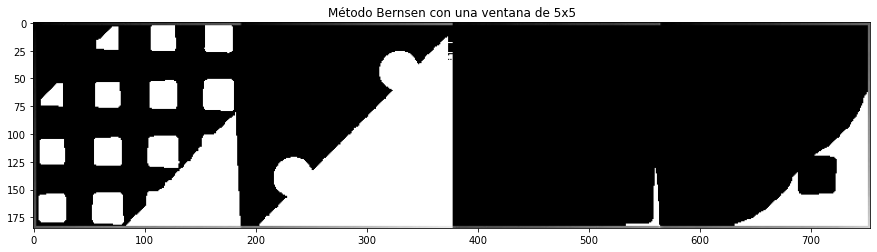

In [12]:
img3=metodo_bernsen_ventana(img,128,5)
plt.figure(figsize=(15,4))
plt.imshow(img3, cmap="gray")
plt.title('Método Bernsen con una ventana de 5x5')
plt.show()

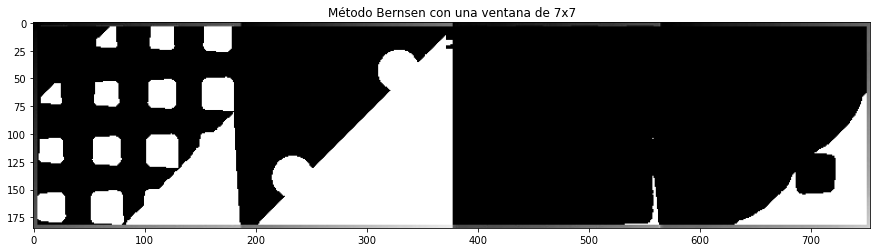

In [13]:
img4=metodo_bernsen_ventana(img,128,7)
plt.figure(figsize=(15,4))
plt.imshow(img4, cmap="gray")
plt.title('Método Bernsen con una ventana de 7x7')
plt.show()

## Análisis de Resultados

+ Del método de Bernsen se obtuvo un gran resalte sobre las imagenes en las tonalidades grises de igual manera para los distintos tamaños de ventana.

## Conclusiones

+ Los métodos locales producen un mejor resultado al binarizar la imagen en situaciones donde la iluminación en el documento es variable. Sin embargo, las limitaciones de procesamiento y memoria lo hacen difícil de implementar en dispositivos móviles.